In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3341, done.
remote: Counting objects: 100% (612/612), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 3341 (delta 531), reused 458 (delta 387), pack-reused 2729 (from 1)
Receiving objects: 100% (3341/3341), 233.19 MiB | 9.28 MiB/s, done.
Resolving deltas: 100% (2581/2581), done.
Updating files: 100% (144/144), done.


In [2]:
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e . -q
!pip install xraydb -q
!pip install xopt -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.6/724.6 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [4]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import trange
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from split_and_delay import SND

import torch
import gpytorch
import botorch
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator, ExpectedImprovementGenerator, TDUpperConfidenceBoundGenerator, TDExpectedImprovementGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs
from xopt import VOCS
from xopt import Xopt

In [52]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*20e-6 - 10e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t4_th1(x[2])
    snd.mvr_t4_th2(x[3])


    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()



    result.append((my_intensity)/(61441.4336))
    del snd
  return torch.tensor(result, dtype=torch.float)

In [27]:
input = np.ones((1,4)) * 1.0
get_snd_outputs(input)

tensor([0.0230])

In [24]:
def f(input_dict: dict) -> dict:
  current_time = time.time()
  t = current_time - start_time
  drift = 0.001
  print(t*drift)
  if t > 20:
    x1, x2, x3, x4 = input_dict["x1"] + t*drift, input_dict["x2"] + t*drift, input_dict["x3"] + t*drift, input_dict["x4"] + t*drift
  else:
    x1, x2, x3, x4 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f = output.item()
  return {"f": f, "time": float(current_time)}

In [7]:
def eval_function(input_dict: dict) -> dict:
  drift = 0.01
  if time > 20:
    x1, x2, x3, x4 = input_dict["x1"] + time*drift, input_dict["x2"] + time*drift, input_dict["x3"] + time*drift, input_dict["x4"] + time*drift
  else:
    x1, x2, x3, x4 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f = output.item()
  return {"f": f}

In [46]:
low = 0.0
high = 1.0
n_init = 64
vocs = VOCS(
    variables = {"x1": [low, high],
                "x2": [low, high],
                "x3": [low, high],
                "x4": [low, high]
                 },
    objectives = {"f": "MAXIMIZE"},
  )

In [50]:
evaluator = Evaluator(function=eval_function)
generator = ExpectedImprovementGenerator(vocs=vocs)

X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
X.random_evaluate(4)

,x1,x2,x3,x4,x5,x6,x7,x8,f,xopt_runtime,xopt_error
0,0.666116,0.737309,0.838618,0.681321,0.476079,0.125754,0.542166,0.488172,0.011611,0.313689,False
1,0.876356,0.324308,0.477965,0.533109,0.194772,0.742806,0.731870,0.406813,0.006161,0.309167,False
2,0.684171,0.245515,0.702164,0.504574,0.667648,0.246021,0.449139,0.506692,0.010519,0.321579,False
3,0.713939,0.892013,0.778083,0.400686,0.929600,0.503280,0.101058,0.133333,0.010136,0.315112,False


In [51]:
time = 0
for i in range(100):
  print(f"Step: {i+1} \t Time: {time}")
  X.step()
  time += 1

Step: 1 	 Time: 0
Step: 2 	 Time: 1
Step: 3 	 Time: 2
Step: 4 	 Time: 3
Step: 5 	 Time: 4
Step: 6 	 Time: 5
Step: 7 	 Time: 6
Step: 8 	 Time: 7
Step: 9 	 Time: 8
Step: 10 	 Time: 9
Step: 11 	 Time: 10
Step: 12 	 Time: 11
Step: 13 	 Time: 12
Step: 14 	 Time: 13
Step: 15 	 Time: 14
Step: 16 	 Time: 15
Step: 17 	 Time: 16
Step: 18 	 Time: 17
Step: 19 	 Time: 18
Step: 20 	 Time: 19
Step: 21 	 Time: 20
Step: 22 	 Time: 21
Step: 23 	 Time: 22
Step: 24 	 Time: 23
Step: 25 	 Time: 24
Step: 26 	 Time: 25
Step: 27 	 Time: 26
Step: 28 	 Time: 27
Step: 29 	 Time: 28
Step: 30 	 Time: 29
Step: 31 	 Time: 30
Step: 32 	 Time: 31
Step: 33 	 Time: 32
Step: 34 	 Time: 33
Step: 35 	 Time: 34
Step: 36 	 Time: 35
Step: 37 	 Time: 36
Step: 38 	 Time: 37
Step: 39 	 Time: 38
Step: 40 	 Time: 39
Step: 41 	 Time: 40
Step: 42 	 Time: 41
Step: 43 	 Time: 42
Step: 44 	 Time: 43
Step: 45 	 Time: 44
Step: 46 	 Time: 45
Step: 47 	 Time: 46
Step: 48 	 Time: 47
Step: 49 	 Time: 48
Step: 50 	 Time: 49
Step: 51 	 Time: 50

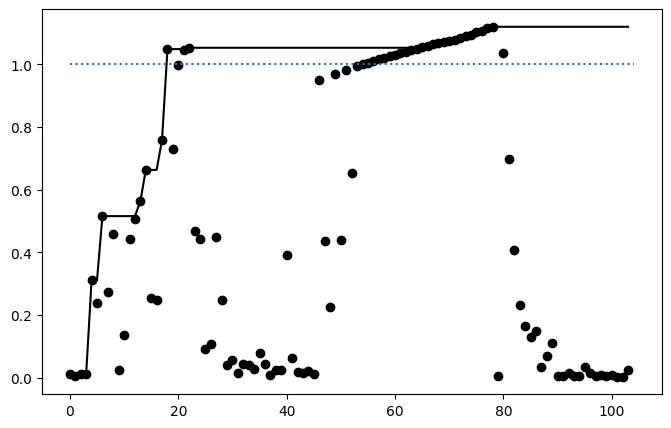

In [52]:
y1 = X.generator.data["f"]
plt.figure(figsize=(8,5))


y1_maxs = np.maximum.accumulate(y1)
plt.plot(y1, 'ok')
plt.plot(y1_maxs, 'k')
plt.hlines(1, 0, len(y1_maxs), linestyles="dotted")
plt.show()

In [ ]:
low = 0.0
high = 1.0

vocs = VOCS(
    variables = {"x1": [low, high],
                "x2": [low, high],
                "x3": [low, high],
                "x4": [low, high]
                 },
    objectives = {"f": "MAXIMIZE"},
  )

evaluator = Evaluator(function=f)

generator = TDUpperConfidenceBoundGenerator(
    vocs=vocs,
    beta=0.001,
    added_time=0.1,
    forgetting_time=25.0,
)
generator.n_monte_carlo_samples = 128
generator.numerical_optimizer.n_restarts = 20
generator.max_travel_distances = [1.0] * 4

start_time = time.time()
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
X.random_evaluate(32)

for i in trange(100):
  print(f"Step: {i+1} \t Time: {time.time() - start_time}")
  X.step()
  time.sleep(0.1)

3.581523895263672e-06
0.0003838765621185303
0.0007121512889862061
0.0010248985290527343
0.0013392374515533447
0.0016647677421569825
0.0019776875972747805
0.002285845518112183
0.0026009809970855714
0.0029109997749328614
0.0032199530601501464
0.003533997058868408
0.0038367884159088137
0.004145174264907837
0.004471184492111206
0.004780854940414429
0.005097412586212159
0.005413716316223145
0.005731792688369751
0.006041719675064087
0.006350425958633423
0.006667555332183838
0.007127586603164673
0.007658645629882813
0.008807661294937133
0.009532578706741334
0.010125797748565674
0.010485443592071533
0.01081972122192383
0.011133440494537353
0.011441065788269044
0.011741965293884278


  0%|          | 0/100 [00:00<?, ?it/s]

Step: 1 	 Time: 12.077725887298584
0.012569627046585083


  1%|          | 1/100 [00:00<01:30,  1.09it/s]

Step: 2 	 Time: 12.992671728134155
0.013553779602050781


  2%|▏         | 2/100 [00:01<01:33,  1.05it/s]

Step: 3 	 Time: 13.972649097442627
0.014545329570770264


  3%|▎         | 3/100 [00:02<01:33,  1.04it/s]

Step: 4 	 Time: 14.946465730667114
0.015446935653686523


  4%|▍         | 4/100 [00:03<01:29,  1.07it/s]

Step: 5 	 Time: 15.837045907974243
0.016361175775527953


  5%|▌         | 5/100 [00:04<01:28,  1.07it/s]

Step: 6 	 Time: 16.764477968215942
0.017292975664138795


  6%|▌         | 6/100 [00:05<01:27,  1.07it/s]

Step: 7 	 Time: 17.697344303131104
0.0182291522026062


  7%|▋         | 7/100 [00:06<01:26,  1.07it/s]

Step: 8 	 Time: 18.628153085708618
0.01923789381980896


  8%|▊         | 8/100 [00:07<01:27,  1.05it/s]

Step: 9 	 Time: 19.63493323326111
0.02026881527900696


  9%|▉         | 9/100 [00:08<01:34,  1.04s/it]

Step: 10 	 Time: 20.854193210601807
0.021724905014038086


 10%|█         | 10/100 [00:10<01:43,  1.14s/it]

Step: 11 	 Time: 22.23797631263733
0.022886291027069093


 11%|█         | 11/100 [00:11<01:39,  1.12s/it]

Step: 12 	 Time: 23.29272699356079
0.023807658433914185


 12%|█▏        | 12/100 [00:12<01:32,  1.06s/it]

Step: 13 	 Time: 24.209024667739868
0.02479804587364197


 13%|█▎        | 13/100 [00:13<01:30,  1.04s/it]

Step: 14 	 Time: 25.19948720932007
0.02581966495513916


 14%|█▍        | 14/100 [00:14<01:28,  1.03s/it]

Step: 15 	 Time: 26.217775583267212
0.026913219928741454


 15%|█▌        | 15/100 [00:15<01:29,  1.05s/it]

Step: 16 	 Time: 27.31495189666748
0.027897151708602907


 16%|█▌        | 16/100 [00:16<01:26,  1.03s/it]

Step: 17 	 Time: 28.299405813217163
0.028778708934783938


 17%|█▋        | 17/100 [00:17<01:21,  1.01it/s]

Step: 18 	 Time: 29.180946826934814
0.02966463351249695


 18%|█▊        | 18/100 [00:17<01:18,  1.05it/s]

Step: 19 	 Time: 30.065844535827637
0.030591469287872316


 19%|█▉        | 19/100 [00:18<01:16,  1.06it/s]

Step: 20 	 Time: 30.989774227142334
0.031707939386367796


 20%|██        | 20/100 [00:20<01:19,  1.00it/s]

Step: 21 	 Time: 32.102843284606934
0.032521000623703


 21%|██        | 21/100 [00:20<01:15,  1.05it/s]

Step: 22 	 Time: 32.95948910713196
0.033506025314331056


 22%|██▏       | 22/100 [00:21<01:17,  1.00it/s]

Step: 23 	 Time: 34.06357979774475
0.03499947214126587


 23%|██▎       | 23/100 [00:23<01:26,  1.12s/it]

Step: 24 	 Time: 35.455092430114746
0.03612536859512329


 24%|██▍       | 24/100 [00:24<01:23,  1.10s/it]

Step: 25 	 Time: 36.525439500808716
0.03738299179077149


 25%|██▌       | 25/100 [00:25<01:26,  1.15s/it]

Step: 26 	 Time: 37.781686544418335
0.038445447206497195


 26%|██▌       | 26/100 [00:26<01:23,  1.13s/it]

Step: 27 	 Time: 38.86302042007446
0.039251959800720215


 27%|██▋       | 27/100 [00:27<01:14,  1.03s/it]

Step: 28 	 Time: 39.65070962905884
0.040491371154785155


 28%|██▊       | 28/100 [00:28<01:18,  1.09s/it]

Step: 29 	 Time: 40.89719772338867
0.04152709650993347


 29%|██▉       | 29/100 [00:29<01:16,  1.08s/it]

Step: 30 	 Time: 41.93877339363098
0.042667027473449706


 30%|███       | 30/100 [00:30<01:16,  1.10s/it]

Step: 31 	 Time: 43.076931953430176
0.043521819591522216


 31%|███       | 31/100 [00:31<01:10,  1.02s/it]

Step: 32 	 Time: 43.915651082992554
0.044276320934295656


 32%|███▏      | 32/100 [00:32<01:04,  1.06it/s]

Step: 33 	 Time: 44.67996335029602
0.045091769456863405


 33%|███▎      | 33/100 [00:33<01:02,  1.08it/s]

Step: 34 	 Time: 45.5670382976532
0.04709884881973267


 34%|███▍      | 34/100 [00:35<01:24,  1.28s/it]

Step: 35 	 Time: 47.67592740058899
0.04846898221969605


 35%|███▌      | 35/100 [00:36<01:21,  1.25s/it]

Step: 36 	 Time: 48.86779975891113
0.050062695264816284


 36%|███▌      | 36/100 [00:38<01:27,  1.36s/it]

Step: 37 	 Time: 50.4762237071991
0.05124127888679505


 37%|███▋      | 37/100 [00:39<01:22,  1.30s/it]

Step: 38 	 Time: 51.64752721786499
0.052394495725631714


 38%|███▊      | 38/100 [00:40<01:17,  1.26s/it]

Step: 39 	 Time: 52.795437812805176
0.05338153672218323


 39%|███▉      | 39/100 [00:41<01:11,  1.18s/it]

Step: 40 	 Time: 53.77997374534607
0.05454599404335022


 40%|████      | 40/100 [00:42<01:10,  1.17s/it]

Step: 41 	 Time: 54.94987201690674
0.05559874200820923


 41%|████      | 41/100 [00:43<01:07,  1.14s/it]

Step: 42 	 Time: 56.0196635723114
0.05703049898147583


 42%|████▏     | 42/100 [00:45<01:11,  1.23s/it]

Step: 43 	 Time: 57.44120717048645
0.058871933460235594


 43%|████▎     | 43/100 [00:47<01:22,  1.45s/it]

Step: 44 	 Time: 59.41223931312561
0.060485579252243044


 44%|████▍     | 44/100 [00:48<01:21,  1.46s/it]

Step: 45 	 Time: 60.898088455200195
0.06173147177696228


 45%|████▌     | 45/100 [00:50<01:16,  1.39s/it]

Step: 46 	 Time: 62.13218402862549
0.06288747572898865


 46%|████▌     | 46/100 [00:51<01:11,  1.32s/it]

Step: 47 	 Time: 63.29169678688049
0.06420003724098206


 47%|████▋     | 47/100 [00:52<01:09,  1.32s/it]

Step: 48 	 Time: 64.60121035575867
0.06558147835731507


 48%|████▊     | 48/100 [00:53<01:09,  1.34s/it]

Step: 49 	 Time: 65.98828887939453
0.06699158573150635


 49%|████▉     | 49/100 [00:55<01:09,  1.36s/it]

Step: 50 	 Time: 67.3976182937622
0.0682132625579834


 50%|█████     | 50/100 [00:56<01:05,  1.32s/it]

Step: 51 	 Time: 68.60963892936707
0.06959730648994446


 51%|█████     | 51/100 [00:57<01:05,  1.34s/it]

Step: 52 	 Time: 69.99902582168579
0.07092414689064026


 52%|█████▏    | 52/100 [00:59<01:06,  1.38s/it]

Step: 53 	 Time: 71.48879623413086
0.07256133437156677


 53%|█████▎    | 53/100 [01:00<01:06,  1.41s/it]

Step: 54 	 Time: 72.95668578147888
0.07416897249221802


 54%|█████▍    | 54/100 [01:02<01:07,  1.47s/it]

Step: 55 	 Time: 74.56669044494629
0.07560648274421693


 55%|█████▌    | 55/100 [01:03<01:05,  1.46s/it]

Step: 56 	 Time: 76.00621223449707
0.07679733514785766


 56%|█████▌    | 56/100 [01:05<01:00,  1.39s/it]

Step: 57 	 Time: 77.21563935279846
0.07826133441925048


 57%|█████▋    | 57/100 [01:06<01:00,  1.40s/it]

Step: 58 	 Time: 78.66463232040405
0.07954360008239746


 58%|█████▊    | 58/100 [01:07<00:57,  1.37s/it]

Step: 59 	 Time: 79.9413845539093
0.08162666606903077


 59%|█████▉    | 59/100 [01:09<01:04,  1.58s/it]

Step: 60 	 Time: 82.02423906326294
0.08433647656440735


 60%|██████    | 60/100 [01:12<01:18,  1.96s/it]

Step: 61 	 Time: 84.85798954963684
0.08653312349319459


 61%|██████    | 61/100 [01:14<01:17,  2.00s/it]

Step: 62 	 Time: 86.95160865783691
0.08907078385353089


 62%|██████▏   | 62/100 [01:17<01:21,  2.16s/it]

Step: 63 	 Time: 89.48201203346252
0.09133702778816223


 63%|██████▎   | 63/100 [01:19<01:21,  2.19s/it]

Step: 64 	 Time: 91.75821781158447
0.09335696077346801


 64%|██████▍   | 64/100 [01:21<01:16,  2.13s/it]

Step: 65 	 Time: 93.75637578964233
0.09625797772407532


 65%|██████▌   | 65/100 [01:24<01:24,  2.41s/it]

Step: 66 	 Time: 96.82479000091553
0.09808840107917786


 66%|██████▌   | 66/100 [01:26<01:14,  2.19s/it]

Step: 67 	 Time: 98.48556613922119
0.0989460735321045


 67%|██████▋   | 67/100 [01:27<00:59,  1.79s/it]

Step: 68 	 Time: 99.35091614723206
0.0997493336200714


 68%|██████▊   | 68/100 [01:28<00:47,  1.50s/it]

Step: 69 	 Time: 100.16205644607544


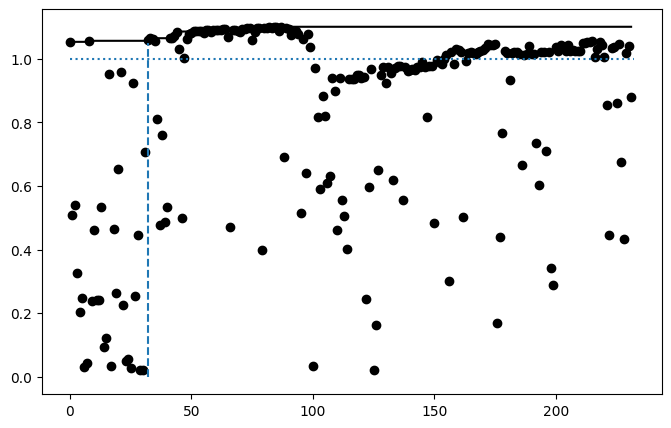

In [51]:
y1 = X.generator.data["f"]
plt.figure(figsize=(8,5))


y1_maxs = np.maximum.accumulate(y1)
plt.plot(y1, 'ok')
plt.plot(y1_maxs, 'k')
plt.hlines(1, 0, len(y1_maxs), linestyles="dotted")
plt.vlines(32, 0, 1.05, linestyles="dashed")
plt.show()

In [10]:
X.data

,x1,x2,x3,x4,f,time,xopt_runtime,xopt_error
0,0.328212,0.617073,0.519231,0.096890,0.287619,1.739939e+09,0.782393,False
1,0.462747,0.771904,0.418003,0.720094,0.275862,1.739939e+09,0.330180,False
2,0.459043,0.872212,0.726375,0.215628,0.252078,1.739939e+09,0.327629,False
3,0.473153,0.135931,0.285710,0.987502,0.383119,1.739939e+09,0.318023,False
4,0.473386,0.100250,0.276396,1.000000,0.324811,1.739939e+09,0.352898,False
...,...,...,...,...,...,...,...,...
99,0.000000,0.768604,0.843395,0.247899,0.015643,1.739939e+09,0.308220,False
100,0.000000,0.746202,0.804714,0.292799,0.015240,1.739939e+09,0.360932,False
101,0.000000,0.751853,0.844432,0.301884,0.014742,1.739939e+09,0.445893,False
102,0.000000,0.784328,0.817761,0.305403,0.014235,1.739939e+09,0.297801,False
